<a href="https://www.kaggle.com/code/yuujapan/ver2-godaddy-microbusiness-density-forecasting?scriptVersionId=125470984" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from sklearn import preprocessing

import warnings
warnings.simplefilter('ignore', FutureWarning)
import time

In [2]:
#データの読み込み
train=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

#activeの指数表記を直す
pd.options.display.float_format = '{:.6f}'.format
train["active"] = train["active"].astype(int)

#データを多く見れるようにする。
pd.set_option('display.max_rows', 5000)

print("OK!!")

OK!!


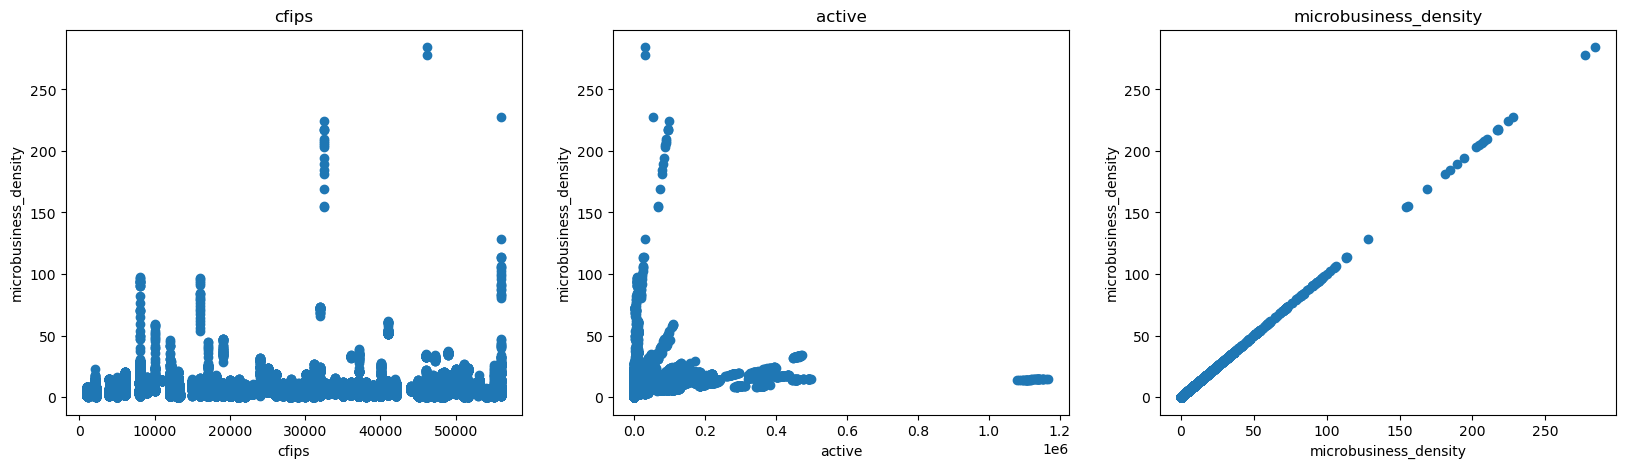

In [3]:
# グラフの大きさを指定する
plt.figure(figsize=(20, 5))
# 2つの特徴に1つの目的変数をつかう。
features = ["cfips", "active","microbusiness_density"]
target = train["microbusiness_density"]

# 2つのグラフを1ページで表示するため
#For文を使い、一つずつグラフ作っていく。
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = train[col] 
    y= target
    plt.scatter(x, y, marker="o")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("microbusiness_density")

<AxesSubplot:>

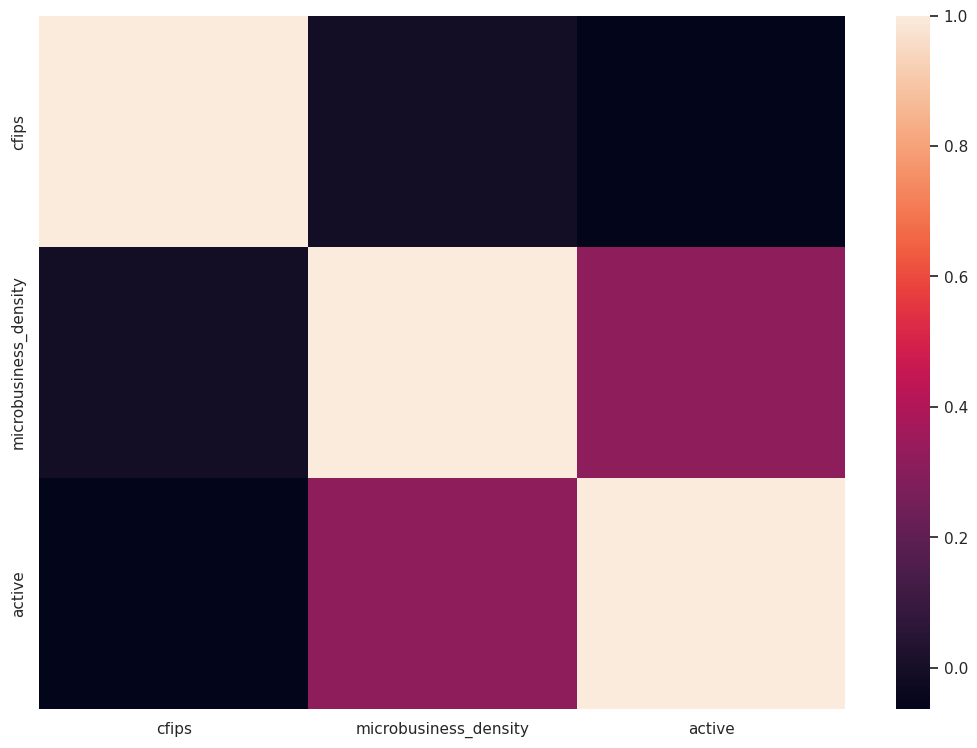

In [4]:
#データの相関関係図
#赤色が０
heatmap = train.corr()
sns.set(rc = {'figure.figsize':(13,9)})
sns.heatmap(heatmap)

In [ ]:
sns.pairplot(train, hue='microbusiness_density', palette="husl")

In [ ]:
train.info()
print("--★--★--★--★--★---")
test.info()

In [ ]:
#NaNの数を見る
train.isnull().sum()

In [ ]:
#data数や平均値などを見る
train.describe()

In [ ]:
train.nunique()

In [ ]:
train.astype('str').describe()

In [ ]:
test

In [ ]:
train

# **trainデータの作成**

In [7]:
#Train　＆train2　用
#行の数をカウント
#train["dcount"] = train.groupby(['cfips'])['row_id']

#ラグ特徴量
train["mbd_lag_1"] = train["microbusiness_density"].shift(1).fillna(0)

#mbd と mbd_lag_1 とのずれ量
train["deviation"] = train["microbusiness_density"] - train["mbd_lag_1"].fillna(0)

#cfipsごとの mbd 平均値
train["cat_mean"] = train.groupby('cfips')["microbusiness_density"].transform("mean")
train["cat_min"] = train.groupby('cfips')["microbusiness_density"].transform("min")
train["cat_max"] = train.groupby('cfips')["microbusiness_density"].transform("max")
train["cat_max-min"] = train["cat_max"] - train["cat_min"]

In [8]:
import category_encoders as ce

#ターゲットエンコーディング
te = ce.CatBoostEncoder(cols=['cfips'])
train['OrderedTE']= te.fit_transform(train['cfips'], train['microbusiness_density'])
print("OK!")


#Label エンコーディング
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
LE = le.fit_transform(train['state'])
LE = pd.Series(LE,name="state_LE")

print("OK!!!")
train = pd.concat([train, LE], axis=1)


#Label エンコーディング　２
le = LabelEncoder()
LE = le.fit_transform(train['county'])
LE = pd.Series(LE,name="county_LE")

print("OK!!!!!!")
train = pd.concat([train, LE], axis=1)

OK!
OK!!!
OK!!!!!!


In [11]:
#予測しきれていない mbdをリストアップ 
#divergenceを作成
#mbd_lag_1 - divergence の作成

Divergence = 3.0   #LightGBMの予想外範囲は50以上

md_filter = train[(train['microbusiness_density'] > Divergence)]   #mbd=??以上のdf
md_filter["divergence"] = md_filter["microbusiness_density"] - Divergence

md_filter2 = md_filter.index
md_filter2 =' '.join(map(str, md_filter2)).split()

train["divergence"] = train['microbusiness_density'].iloc[md_filter2] - Divergence
train["divergence"] = train["divergence"].fillna(0)

############
train['microbusiness_density'] = train['microbusiness_density'] - train["divergence"]


In [ ]:
train['microbusiness_density'].describe()

In [ ]:
#予測しきれていないもの ＋削除
"""
md_filter = train[(train['microbusiness_density'] > Divergence)]  
print(len(md_filter))

mdarray = md_filter["cfips"].unique()
md_target = train[(train['cfips'].isin(mdarray))]
train = train.drop(md_target.index.unique())

In [ ]:
#年月日の分割
"""
train['first_day_of_month'] = pd.to_datetime(train["first_day_of_month"])
train["year"] = train["first_day_of_month"].dt.year
train["month"] = train["first_day_of_month"].dt.month

In [ ]:
"""
#One-hot エンコーディング
ohe = pd.get_dummies(train['county'])
pd.concat([train, ohe], axis=1)

# # **分析用データ作成の開始**

**重回帰分析用DF作成**

In [12]:
#重回帰分析用2次元配列 DF
train2 = train[["active","cfips",'mbd_lag_1','OrderedTE',"deviation","county_LE","state_LE","divergence","cat_mean","cat_min","cat_max","cat_max-min"]]
train2 = train2.replace([np.inf, -np.inf], np.nan).fillna(0)
    #無限大などの穴埋め

In [13]:
#トレーニングデータとテストデータの分割 train2
# .values で numpy配列に変換できる。
X_train, X_test, Y_train, Y_test = train_test_split(train2,train["microbusiness_density"], train_size=0.3, shuffle=False)

In [ ]:
#print(train.columns.tolist())

# **Train + Test データの作成と再分割**

In [ ]:
#データ制作開始

train_test = pd.DataFrame(index=[], columns=[])
#Trainデータとtestデータの区別ができるように。
train["train_or_test"] = 0
test["train_or_test"] = 1

#trainとtestの行を結合
train_test = pd.concat((train, test)).sort_values(["cfips",'row_id']).reset_index(drop=True).interpolate('ffill')
train_test["train_or_test"] = train_test["train_or_test"].fillna(1)

"""
train_test['first_day_of_month'] = pd.to_datetime(train_test["first_day_of_month"])
train_test["year"] = train_test["first_day_of_month"].dt.year
train_test["month"] = train_test["first_day_of_month"].dt.month
"""

#平均にする場合　＝ .transform('mean').ffill()
train_test["divergence"] = train_test.groupby('cfips')["divergence"].ffill()

train_test['mbd_lag_1'] = train_test.groupby('cfips')['mbd_lag_1'].ffill() 


train_test['OrderedTE'] = train_test.groupby('cfips')['OrderedTE'].ffill()
train_test['active'] = train_test.groupby('cfips')['active'].ffill()
train_test["deviation"] = train_test.groupby('cfips')['deviation'].ffill()

train_test["state_LE"] = train_test.groupby('cfips')['state_LE'].ffill()
train_test["county_LE"] = train_test.groupby('cfips')['county_LE'].ffill()

train_test["cat_mean"] = train_test.groupby('cfips')['cat_mean'].ffill()
train_test["cat_min"] = train_test.groupby('cfips')['cat_min'].ffill()
train_test["cat_max"] = train_test.groupby('cfips')['cat_max'].ffill()
train_test["cat_max-min"] = train_test.groupby('cfips')['cat_max-min'].ffill()


#結合したロール特徴量　をずらす。
train_test['roll_1'] = train_test.groupby('cfips')['roll_1'].ffill().shift(1) 
train_test['roll_2'] = train_test.groupby('cfips')['roll_2'].ffill().shift(2) 
train_test['roll_3'] = train_test.groupby('cfips')['roll_3'].ffill().shift(3) 
train_test['roll_4'] = train_test.groupby('cfips')['roll_4'].ffill().shift(4) 
train_test['roll_5'] = train_test.groupby('cfips')['roll_5'].ffill().shift(5) 
train_test['roll_6'] = train_test.groupby('cfips')['roll_6'].ffill().shift(6) 
train_test['roll_7'] = train_test.groupby('cfips')['roll_7'].ffill().shift(7) 

train_test['roll_1'] = train_test['roll_1'] - train_test["divergence"].shift(1)
train_test['roll_2'] = train_test['roll_2'] - train_test["divergence"].shift(2)
train_test['roll_3'] = train_test['roll_3'] - train_test["divergence"].shift(3)
train_test['roll_4'] = train_test['roll_4'] - train_test["divergence"].shift(4)
train_test['roll_5'] = train_test['roll_5'] - train_test["divergence"].shift(5)
train_test['roll_6'] = train_test['roll_6'] - train_test["divergence"].shift(6)
train_test['roll_7'] = train_test['roll_7'] - train_test["divergence"].shift(7)
    
#NaNの数を見る
train_test.isnull().sum()

In [ ]:
train_test

In [ ]:
#TrainとTestの再分割
#行番号の降り直し
train_test = train_test[train_test["train_or_test"] == 1].reset_index(drop=True)
train_test.index =  np.arange(1, len(train_test)+1)
 

In [ ]:
#いらない列の削除 train_test
train_test = train_test.drop(["row_id","county","state","first_day_of_month","train_or_test"], axis=1)

In [ ]:
#削除のみ
train_test = train_test.drop("microbusiness_density",axis=1)

In [ ]:
train_test[25000:]

# # **トレーニング・予測の開始**

In [14]:
!pip install optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [15]:
#ハイパーパラメーター  ランダムフォレスト
#回帰専用　＝ objective = regression に変更
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def objective(trial):
    max_features = trial.suggest_categorical("max_features", [None]) #'sqrt', 'log2'
    n_estimators = int(trial.suggest_discrete_uniform("n_estimators", 20,500,20))
    max_depth = trial.suggest_int("max_depth", 3,15)
    global clf
    
    #RandomForestRegressor
    clf = RandomForestRegressor(random_state=1, n_estimators = n_estimators, max_features = max_features, max_depth=max_depth)
    
    clf.fit(X_train, Y_train)
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)

print("-----mean_squared_error----")
np.sqrt(mean_squared_error(Y_test,clf.predict(X_test)))

print("-----R2----1に近いほど良い")
r2 = r2_score(Y_test,clf.predict(X_test))
print('R2 :',r2)



[I 2023-04-12 04:00:10,187] A new study created in memory with name: no-name-96c01d1b-63c6-4fd1-b3b9-43b3f40329c6
[W 2023-04-12 04:00:20,555] Trial 0 failed with parameters: {'max_features': None, 'n_estimators': 460.0, 'max_depth': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27/2371479503.py", line 16, in objective
    clf.fit(X_train, Y_train)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parall

KeyboardInterrupt: 

[I 2023-04-12 04:00:25,227] A new study created in memory with name: no-name-1f8e71c2-9565-4ea0-9166-4664edd19363
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2023-04-12 04:00:28,185] Trial 0 finished with value: 0.06674229336240056 and parameters: {'max_depth': 70, 'boosting_type': 'dart', 'min_child_samples': 835, 'max_bin': 4861, 'metric': 'l2'}. Best is trial 0 with value: 0.06674229336240056.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00228891	valid_0's l2: 0.00273152


[I 2023-04-12 04:00:29,983] Trial 1 finished with value: 0.004377705465863246 and parameters: {'max_depth': 78, 'boosting_type': 'gbdt', 'min_child_samples': 730, 'max_bin': 4259, 'metric': 'l2'}. Best is trial 1 with value: 0.004377705465863246.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2023-04-12 04:00:32,511] Trial 2 finished with value: 0.06503890887397679 and parameters: {'max_depth': 70, 'boosting_type': 'dart', 'min_child_samples': 558, 'max_bin': 4901, 'metric': 'l2'}. Best is trial 1 with value: 0.0043777

Training until validation scores don't improve for 100 rounds


[I 2023-04-12 04:00:39,633] Trial 5 finished with value: 0.003909546908448802 and parameters: {'max_depth': 61, 'boosting_type': 'goss', 'min_child_samples': 402, 'max_bin': 3180, 'metric': 'l2'}. Best is trial 5 with value: 0.003909546908448802.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.0021357	valid_0's l2: 0.00243941


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2023-04-12 04:00:42,212] Trial 6 finished with value: 0.06272653368753445 and parameters: {'max_depth': 95, 'boosting_type': 'dart', 'min_child_samples': 252, 'max_bin': 4955, 'metric': 'l2'}. Best is trial 5 with value: 0.003909546908448802.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00260282	valid_0's l2: 0.00302975


[I 2023-04-12 04:00:44,891] Trial 7 finished with value: 0.004855664008268312 and parameters: {'max_depth': 50, 'boosting_type': 'gbdt', 'min_child_samples': 878, 'max_bin': 3451, 'metric': 'l2'}. Best is trial 5 with value: 0.003909546908448802.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00206635	valid_0's l2: 0.00249194


[I 2023-04-12 04:00:46,749] Trial 8 finished with value: 0.003993739622914716 and parameters: {'max_depth': 74, 'boosting_type': 'gbdt', 'min_child_samples': 609, 'max_bin': 4025, 'metric': 'l2'}. Best is trial 5 with value: 0.003909546908448802.
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00167297	valid_0's l2: 0.00229979


[I 2023-04-12 04:00:48,625] Trial 9 finished with value: 0.003685791310157005 and parameters: {'max_depth': 30, 'boosting_type': 'goss', 'min_child_samples': 324, 'max_bin': 4305, 'metric': 'l2'}. Best is trial 9 with value: 0.003685791310157005.


---正答率---
0.996314208689843
{'max_depth': 30, 'boosting_type': 'goss', 'min_child_samples': 324, 'max_bin': 4305, 'metric': 'l2'}


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

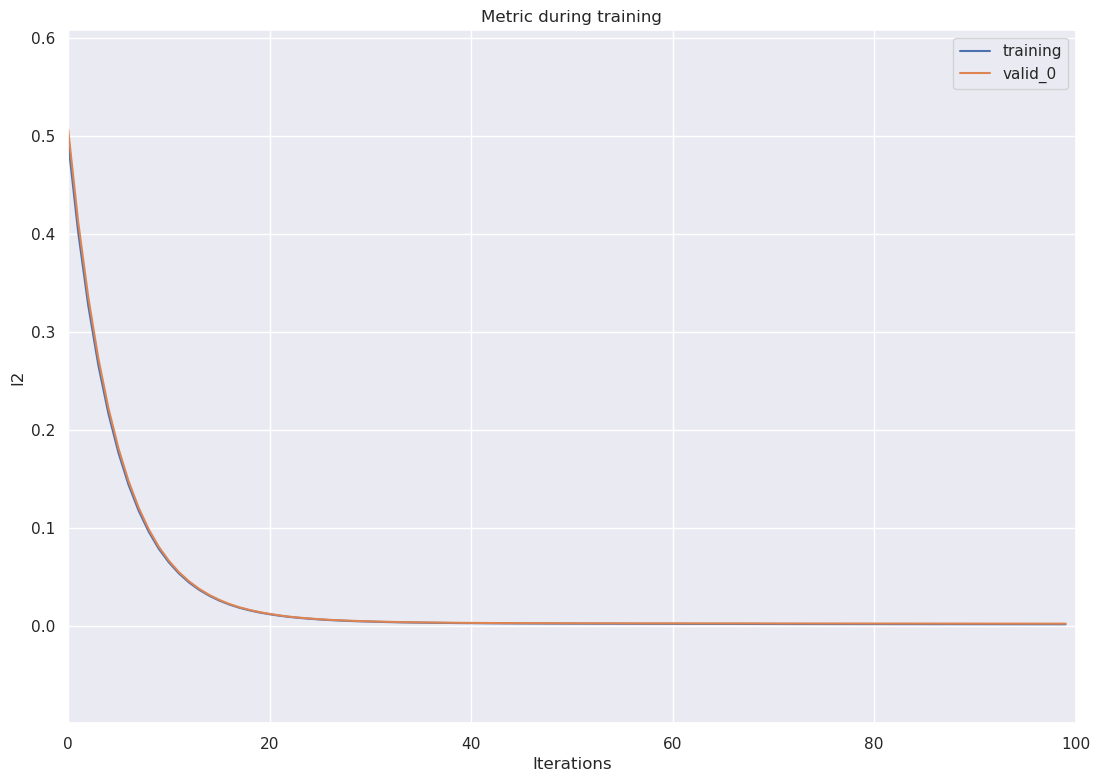

In [16]:
#ハイパーパラメーター  LightGBM
#回帰専用　＝ objective = regression に変更
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 10,100)
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt","dart","goss"])
    #learning_rate = trial.suggest_float("learning_rate", 0.005,0.0075)  #使うと成績が悪くなる。
    min_child_samples = trial.suggest_int("min_child_samples", 200,1000)
    max_bin = trial.suggest_int("max_bin", 3000,5000) #default 255
    metric = trial.suggest_categorical("metric", ["l2"])
    global clf
    
    #LGBMRegressor
    clf = lgb.LGBMRegressor(metric=metric,max_bin=max_bin,min_child_samples=min_child_samples ,boosting_type = boosting_type, max_depth=max_depth,random_seed=42)

    clf.fit(X_train, Y_train,eval_set=[(X_test, Y_test), (X_train, Y_train)],eval_metric= "l2",verbose=False,callbacks=[lgb.early_stopping(stopping_rounds=100)])
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)

lgb.plot_metric(clf)

In [ ]:
#XGBoost   mbd = 45以上が外れる。

#ハイパーパラメーター  XGBoost
#回帰専用　＝ objective = regression に変更
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 10,100)
    gamma = trial.suggest_float("gamma", 0,0.2)

    global clf
    
    #LGBMRegressor
    clf = xgb.XGBRegressor(max_depth = max_depth,gamma = gamma, early_stopping_rounds=10)

    clf.fit(X_train, Y_train,eval_set=[(X_test, Y_test), (X_train, Y_train)],verbose=False)
    return 1 - r2_score(Y_test, clf.predict(X_test)) 

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("---正答率---")
print(1-study.best_value)
print(study.best_params)


In [ ]:
import matplotlib.pyplot as plt
#特徴量の重要度
feature = clf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()
print(label)


,Data,Predicted
36679,1.135826,1.125109
36680,1.230478,1.276933
36681,1.230478,1.234814
36682,1.230478,1.234295
36683,1.230478,1.234295
...,...,...
122260,1.803249,1.801870
122261,1.803249,1.801870
122262,1.785395,1.777899
122263,1.785395,1.797536


Text(0.5, 1.0, 'y vs y_pred')

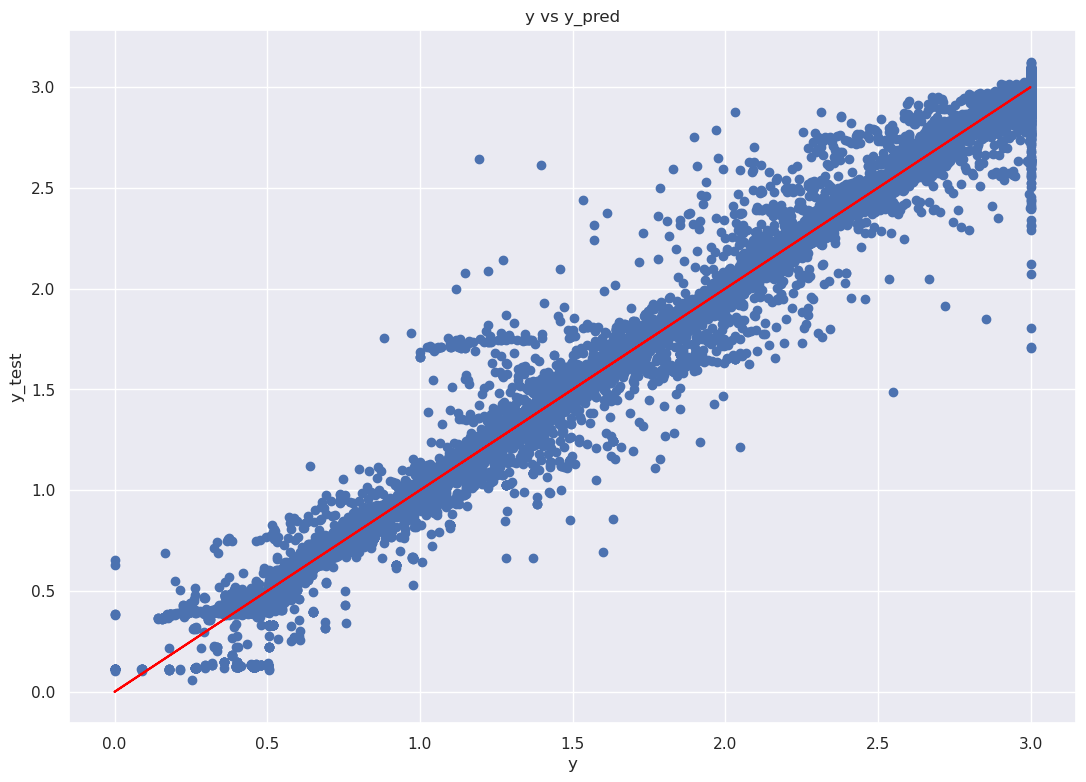

In [17]:

# 真値と予測値の表示
y_pred = clf.predict(X_test)
df_pred = pd.DataFrame({'Data':Y_test,'Predicted':y_pred})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(Y_test, Y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(Y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル


In [ ]:
Y_test.describe()

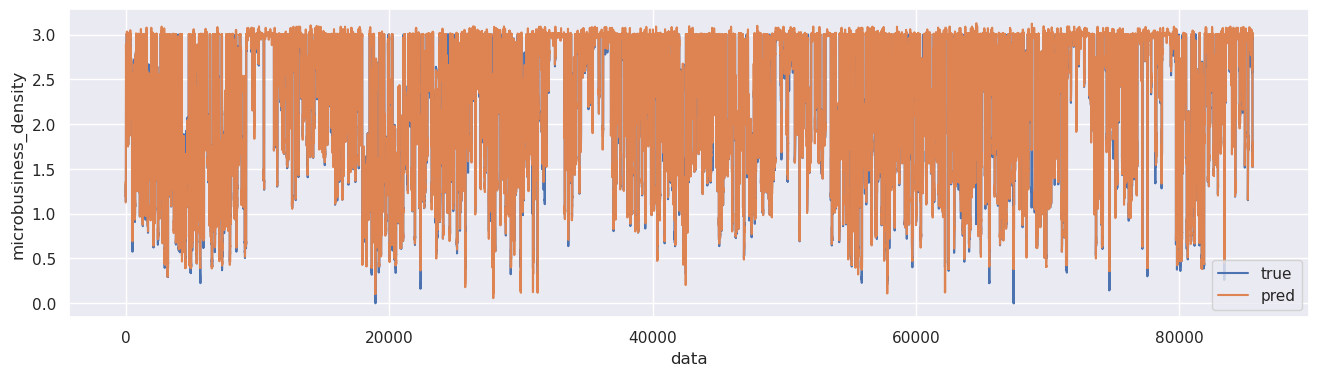

In [18]:
# 予測値と実測値の折れ線図
plt.figure(figsize=(16,4))
plt.plot(Y_test.reset_index(drop=True), label='true')
plt.plot(y_pred, label='pred')

plt.xlabel('data')
plt.ylabel('microbusiness_density')
# plt.xlim(0,1000)
plt.legend()

plt.show()

In [ ]:
train_test[0:50]

In [ ]:
#1行ずつpredictした値を　ラグ特徴量に入れて書き換える
"""
for x in range(len(train_test)):
    train_test.loc[x+1,"roll_1"] = clf.predict(train_test[x:x+1])
    
    if x % 1000 == 0:
        print(x)
    
    elif (x+1) % 8 == 0:
        continue

# **実際に予測する**

In [ ]:
#実際に予測する
#test = test.drop("microbusiness_density",axis=1)
train_test = train_test.dropna()
train_test = train_test.drop(train_test.index[25080:])
predicted_2 = clf.predict(train_test)
predicted_2

In [ ]:
predicted_2[0:50]

In [ ]:
#DFに書き込むためのデータを呼び出す。
test2 = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
test2 = test2.sort_values(["cfips","first_day_of_month"],ascending=True)

In [ ]:
#答えをDFにする
test2["microbusiness_density"] = predicted_2

#df_answer = pd.DataFrame(data={"row_id":test2["row_id"],,"microbusiness_density":predicted_2})
#df_answer

#答えをソート　提出例に合わせて作る
test2 = test2.sort_values(["first_day_of_month","cfips"])
#test2 = test2.drop(["first_day_of_month","cfips"],axis=1)

In [ ]:
#Divergence　ずれを反映させるためのdf。
test3 = pd.DataFrame(data=[])
test3["cfips"] = md_filter["cfips"]  #mbd=?? 以上のdf のcfips ユニーク値
test3["divergence"] = md_filter["divergence"] # すれ 
test3 = test3.drop_duplicates(subset='cfips')   #重複行の削除

#テストデータとdivergenceを結合後、予測したmbdに足す。

In [ ]:
list(md_filter["divergence"].unique())

In [ ]:
#test2 と test3　をマージ
test4 = pd.merge(test2, test3,on='cfips',how='outer')
test4["divergence"] = test4["divergence"].fillna(0)

test4 = test4.sort_values(["first_day_of_month","cfips"])
test4["microbusiness_density"] = test4["microbusiness_density"] + test4["divergence"]
test5 = test4.drop(["first_day_of_month","cfips","divergence"],axis=1)
test5 = test5.reset_index(drop=True)
test5

In [ ]:
sample

In [ ]:
test4.sort_values(["cfips","row_id"])[0:20]

In [ ]:
#完成したCSVを名前を変えて保存する #インデックス（行番号）なし
test5.to_csv('/kaggle/working/godaddy90.csv',index = False)

In [ ]:
import pickle
#学習モデルの保存
with open('/kaggle/working/godaddy.pickle', mode='wb') as f:
    pickle.dump(clf,f,protocol=2)

In [ ]:
import pickle
# モデルのオープン
with open('/kaggle/working/godaddy.pickle', mode='rb') as f:
    clf = pickle.load(f)

**censusからmicrobusinessdensityを予測。**

In [ ]:
census

In [ ]:
#trainとcensusの結合

train3 = pd.merge(train,census, on='cfips').fillna(0)
#train3.isnull().sum()
train3.drop(["row_id","county","state","first_day_of_month"])

In [ ]:
train3

# # **コードのメモ**

In [ ]:
#trainとcensusの結合
"""
train = pd.merge(train,census, on='cfips').fillna(0)
train.isnull().sum()
"""

In [ ]:
#予測しきれていない mbdをリストアップ
md_filter = train[(train['microbusiness_density'] > 30)]
print(len(md_filter))

#リストアップして,同じcfipsのものを全削除
mdarray2 = set(md_filter["cfips"].index) & set(md_filter['cfips'].index) #setで行番号を比較、辞書形式になる。

mdarray2= list(mdarray2)                          #辞書からリストに直す。
' '.join(map(str, mdarray2)).split()              #文字列に変換して、スペースでsplit
print(len(mdarray2))

train = train.drop(train.index[mdarray2],axis=0)  #行番号を指定して削除

In [ ]:
train.loc[(train['microbusiness_density'] > 20),['microbusiness_density']] = train['microbusiness_density']-20
#df1.loc[df1["c3"]>3, ["c3"]]=1
md_filter

# **ARIMA モデル**

In [ ]:
#データの読み込み
train=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample=pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

#activeの指数表記を直す
pd.options.display.float_format = '{:.6f}'.format
train["active"] = train["active"].astype(int)

In [ ]:
#ARIMA自己回帰　　インストール時間かかる
!pip install git+https://github.com/RJT1990/pyflux

In [ ]:
#ARIMA自己回帰
#時系列データに強い

import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#時系列
train_test.index = train_test.index

model = pf.ARIMA(data=train_test, ar=1, ma=1, target='microbusiness_density', family=pf.Normal())


In [ ]:
x = model.fit('MLE')  #Inference option: e.g. ‘M-H’ or ‘MLE’

In [ ]:
x.summary()
model.plot_predict_is(h=1000 ,figsize=(20, 5)) #h=どれだけの数を予測するか

In [ ]:
result = model.predict(h=len(train_test)-1)

In [ ]:
result = result.sort_index(ascending=False).reset_index(drop=True)
result = result.append({'microbusiness_density':0.0}, ignore_index=True)

In [ ]:
result

In [ ]:
train_test

In [ ]:
#最初にtrain?testをカットしない場合。
cut_index = train_test[train_test["train_or_test"] == 1].index
result_index = result.index
result_end = result[result_index.isin(cut_index)]
result_end = result_end.reset_index(drop=True)
result_end

In [ ]:
#DFに書き込むためのデータを呼び出す。
test2 = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

In [ ]:
#答えをDFにする
test2["microbusiness_density"] = result["microbusiness_density"]

#df_answer = pd.DataFrame(data={"row_id":test2["row_id"],,"microbusiness_density":predicted_2})
#df_answer

#答えをソート　提出例に合わせて作る
test2 = test2.sort_values(["first_day_of_month","cfips"])
test2 = test2.drop(["first_day_of_month","cfips"],axis=1)

In [ ]:
test2

In [ ]:
sample

In [ ]:
#完成したCSVを名前を変えて保存する #インデックス（行番号）なし
test2.to_csv('/kaggle/working/godaddy74.csv',index = False)

# # **ARIMAXモデル**

In [ ]:
#時系列データにはない外部要因を入れて評価したい場合があります。そのような場合はARIMAXを使用します。
#予測後にパラメータを加えて再度予測
model = pf.ARIMAX(data=train, formula='microbusiness_density~1+cat_mean',
                 ar=1, ma=1, family=pf.Normal())
x = model.fit('MLE')

x.summary()
model.plot_predict_is(h=200 ,figsize=(20, 5)) #h=どれだけの数を予測するか

In [ ]:
model.predict(h=20)

In [ ]:
pd.set_option('display.max_rows', 5000)
test
